# Estudo de Superfícies com SageMath
**Autor:** Leonardo Dantas

Formas fundamentais representam um rico tópico da geometria diferencial. Através da computação simbólica, este trabalho explora a construção, visualização e estudo de superfícies no espaço e suas formas fundamentais. Unindo conceitos teóricos a implementação em código, a análise a seguir é construída em cima da plataforma [SageMath](https://www.sagemath.org/).

O trabalho é dividido em 5 partes:

1. Ambiente SageMath
2. Conceitos Teóricos
3. Superfícies Gerais
4. Superfícies Regradas
5. Desenvolvíveis Tangentes

Como formatação, este caderno interativo Jupyter usa os estilos do curso [Practical Numerical Methods with Python](https://github.com/numerical-mooc/numerical-mooc), com código licenciado sob a MIT license (c) 2014 L.A. Barba, C. Cooper, G.F. Forsyth, A. Krishnan. Para carregá-los, basta executar a célula seguinte.

In [1]:
# Carregar estilo do caderno
from IPython.core.display import HTML
from os import getcwd
css_file = f'{getcwd()}/styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())

## 1. Ambiente SageMath

Antes de tudo, iniciamos o ambiente de visualização em LaTeX e importamos funções customizadas úteis.

In [2]:
# Habilitar exibição de LaTeX
%display latex

# Funções úteis para o SageMath
from utils import vector_simplify, pretty_results

Dessas funções, `vector_simplify` permite simplificar algebricamente curvas paramétricas, enquanto `pretty_results` exibe resultados formatados em LaTeX.

## 2. Conceitos Teóricos

Como ponto de partida, consideramos conceitos de geometria diferencial importantes para esta análise. Analisaremos a definição de cada conceito e sua implementação em código.

### Primeira Forma Fundamental

Um dos pilares deste trabalho, a *primeira forma fundamental* fornece instrumentos para medir áreas em superfícies. Dada uma carta $X(u,v)$ de uma superfície $C$, a primeira forma fundamental é dada por

$$
E := \langle X_u, X_u \rangle \\
F := \langle X_u, X_v \rangle \\
G := \langle X_v, X_v \rangle
$$

Implementamos a primeira forma fundamental através das funções de diferenciação simbólica e simplificação do SageMath.

In [3]:
def obter_primeira_forma(carta, u, v):
    x_u = derivative(carta, u)
    x_v = derivative(carta, v)
    
    # Primeira Forma Fundamental
    E = x_u.dot_product(x_u)
    F = x_u.dot_product(x_v)
    G = x_v.dot_product(x_v)
    
    # Simplificação
    E = E.full_simplify().canonicalize_radical()
    F = F.full_simplify().canonicalize_radical()
    G = G.full_simplify().canonicalize_radical()
    
    return E,F,G

### Vetor Normal Unitário

Outro objeto relevante nesta análise será o *vetor normal à superfície unitário*, definido por

$$
\mathbf{N} := \frac{ X_u \times X_v  }{ || X_u \times X_v || }
$$



In [4]:
def obter_normal_unitario(carta, u, v):
    x_u = derivative(carta, u)
    x_v = derivative(carta, v)
    
    normal = x_u.cross_product(x_v)(u,v)
    
    normal_unitario = normal / normal.norm()
    normal_unitario = vector_simplify(normal_unitario, 
                                      use_canonical_form=True)
    
    return normal_unitario

### Segunda Forma Fundamental

Com o vetor normal à superfície unitário $\mathbf{N}$, é possível definir a *segunda forma fundamental*. Sua principal contribuição consiste em permitir a descrição da curvatura de uma determinada superfície. Por definição, a segunda forma fundamental é dada por

$$
\begin{align*}
    L &:= X_{uu} \cdot \mathbf{N} \\
    M &:= X_{uv} \cdot \mathbf{N} \\
    N &:= X_{vv} \cdot \mathbf{N}
\end{align*}
$$


In [5]:
def obter_segunda_forma(carta, u,v):
    # Derivadas de Primeira e Segunda Ordem da Carta
    x_u = derivative(carta, u)
    x_v = derivative(carta, v)
    
    x_uu = derivative(x_u, u)
    x_uv = derivative(x_u, v)
    x_vv = derivative(x_v, v)
    
    # Vetor Normal Unitário à Superfície
    vetor_N = obter_normal_unitario(carta, u, v)
    
    # Segunda Forma Fundamental
    l = vetor_N.dot_product(x_uu)
    m = vetor_N.dot_product(x_uv)
    n = vetor_N.dot_product(x_vv)
    
    # Simplificação
    l = l.full_simplify().canonicalize_radical()
    m = m.full_simplify().canonicalize_radical()
    n = n.full_simplify().canonicalize_radical()
    
    return l, m, n

### Operador de Forma

Conhecido também como *mapa de Weingarten*, o *operador de forma*, permite estudar a superfície em um determinado ponto. Em essência, encontrar o operador de forma consiste em usar a primeira e a segunda formas fundamentais para encontrar os valores das equações de Weingarten. 

$$
\begin{gather*}
    \begin{aligned}
        a &= \frac{ LG - MF }{ EG - F^2 } \\
        b &= \frac{ ME - LF }{ EG - F^2 } 
    \end{aligned}
    \quad
    \begin{aligned}
        c &= \frac{ MG - NF }{ EG - F^2 } \\
        d &= \frac{ NE - MF }{ EG - F^2 }
    \end{aligned}
\end{gather*}
$$


Em seguida, é possível expressar o operador de duas maneiras. Seguindo Oprea, uma opção é escrevê-lo como

$$
\begin{align*}
    S(x_u) &:= a x_u + b x_v \\
    S(x_v) &:= c x_u + d x_v
\end{align*} 
$$

Outra forma consiste em representá-lo como a matriz $W$.

$$
W :=
\begin{bmatrix}
    a && b \\
    c && d
\end{bmatrix}
$$

Implementaremos ambas as abordagens. Note que o operador de forma é sempre referente a um ponto específico. 

In [6]:
def obter_operador_forma(carta, u, v):
    # Formas Fundamentais
    e, f, g = obter_primeira_forma(carta, u, v)
    l, m, n = obter_segunda_forma(carta, u, v)
    
    # Fator de Área
    # Norma Quadrada do Vetor Normal induzido pela Base Tangente
    termo_norm = e*g - f^2
    
    # Equações de Weingarten
    a = ( l*g - m*f ) / termo_norm
    b = ( m*e - l*f ) / termo_norm
    c = ( m*g - n*f ) / termo_norm
    d = ( n*e - m*f ) / termo_norm
    
    # Operador de Forma
    x_u, x_v = var('X_u, X_v')
    forma_u(x_u) = a*x_u + b*x_v
    forma_v(x_v) = c*x_u + d*x_v
    
    # Simplificação
    forma_u = forma_u.full_simplify().canonicalize_radical()
    forma_v = forma_v.full_simplify().canonicalize_radical()
    
    return forma_u, forma_v

In [7]:
def obter_matriz_forma(carta, u, v):
    # Formas Fundamentais
    e, f, g = obter_primeira_forma(carta, u, v)
    l, m, n = obter_segunda_forma(carta, u, v)
    
    # Fator de Área
    # Norma Quadrada do Vetor Normal induzido pela Base Tangente
    termo_norm = e*g - f^2
    
    # Equações de Weingarten
    a = ( l*g - m*f ) / termo_norm
    b = ( m*e - l*f ) / termo_norm
    c = ( m*g - n*f ) / termo_norm
    d = ( n*e - m*f ) / termo_norm
    
    # Simplificação
    a = a.full_simplify().canonicalize_radical()
    b = b.full_simplify().canonicalize_radical()
    c = c.full_simplify().canonicalize_radical()
    d = d.full_simplify().canonicalize_radical()
    
    # Matriz de Forma
    matriz_forma = Matrix([ [a, c], [b, d] ])
    
    return matriz_forma

### Curvatura

Diferentes conceitos de curvatura coexistem em geometria diferencial.

Denominamos de *curvaturas principais* de $C$ os autovalores $\kappa_1$ e $\kappa_2$ de $W_C$. Assim, temos

In [8]:
def obter_curv_princ(carta, u, v):
    matriz_forma = obter_matriz_forma(carta, u, v)
    kappa_1, kappa_2 = matriz_forma.eigenvalues()
    
    return kappa_1, kappa_2

Conhecemos como *curvatura gaussiana* a quantidade

$$
\begin{align*}
    K &= \det\left( W \right) \\
      &= \kappa_1 \kappa_2
\end{align*}
$$

Implementado em SageMath, isto é

In [9]:
def obter_curv_gauss(carta, u, v):
    matriz_forma = obter_matriz_forma(carta, u, v)
    curv_gauss = matriz_forma.determinant().full_simplify()
    
    return curv_gauss

Além disso, chamamos de *curvatura média* a quantidade

$$
H = \frac{ \kappa_1 + \kappa_2 }{2}
$$

In [10]:
def obter_curv_media(carta, u, v):
    kappa_1, kappa_2 = obter_curv_princ(carta, u, v)
    h = ( kappa_1 + kappa_2 ) / 2
    
    return h

Por fim, examinaremos o conceito de *curvatura normal*. Oprea define a curvatura normal de uma superfície como

$$
k(u) := S_p(u) \cdot u
$$

onde $p \in C$, $u \in T_p(C)$ e $S$ representa o operador de forma .

In [11]:
def obter_curv_normal(carta, u, v, u0, v0, vetor_unit, teta):
    matriz_forma = obter_matriz_forma(carta, u, v)
    matriz_forma = matriz_forma.subs([u==u0, v==v0])
    
    curv_normal = ( matriz_forma*vetor_unit ).dot_product(vetor_unit)
    
    return curv_normal(teta)

## 3. Superfícies Gerais

Nessa seção, examinaremos algumas superfícies gerais interessantes e suas propriedades. No geral, seguiremos o fluxo de exemplos delineado em Oprea, analisando conceitos teóricos que são relevantes ou interessantes em cada superfície.

### Superfície de Enneper

Uma superfície particularmente curiosa é a *superfície de Enneper*, que pode ser gerada a partir da seguinte carta.

$$
\text{Enneper}(u,v) := 
\left( 
    u - \frac{u^3}{3} + u v^2, 
    v - \frac{v^3}{3} + v u^2
    u^2 - v^2
\right)
$$

Em SageMath, instanciamos a carta da seguinte forma.

In [12]:
enneper(u,v) = ( u - (u^3)/3 + u*v^2, v - (v^3)/3 + v*u^2, u^2 - v^2 )

Instanciada a superfície, é possível plotá-la.

In [13]:
parametric_plot3d(enneper,(u, -3, 3), (v, -3, 3), mesh=True)

Graphics3d Object

Em seguida, analisamos as formas fundamentais da superfície. Como primeira forma fundamental, temos

In [14]:
e, f, g = obter_primeira_forma(enneper, u, v)

pretty_results((r"E", e), (r"F", f), (r"G", g))

\begin{align*} E &= u^{4} + v^{4} + 2 \, {\left(u^{2} + 1\right)} v^{2} + 2 \, u^{2} + 1 \\ F &= 0 \\ G &= u^{4} + v^{4} + 2 \, {\left(u^{2} + 1\right)} v^{2} + 2 \, u^{2} + 1 \\ \end{align*} \\

Observe que $F=0$ indica que os vetores $X_u$ e $X_v$ são ortogonais. Calculamos em seguida o vetor normal unitário.

In [15]:
vetor_normal_unit = obter_normal_unitario(enneper, u, v)
pretty_results((r"\text{NormalUnitário}", vetor_normal_unit))

\begin{align*} \text{NormalUnitário} &= \left(-\frac{2 \, u}{u^{2} + v^{2} + 1},\,\frac{2 \, v}{u^{2} + v^{2} + 1},\,-\frac{u^{2} + v^{2} - 1}{u^{2} + v^{2} + 1}\right) \\ \end{align*} \\

Com isso, obtemos a segunda forma fundamental.

In [16]:
l, m, n = obter_segunda_forma(enneper, u, v)
pretty_results((r"L", l), (r"M", m), (r"N", n))

\begin{align*} L &= 2 \\ M &= 0 \\ N &= -2 \\ \end{align*} \\

Por fim, analisamos o operador de forma.

In [17]:
enneper_forma_u, enneper_forma_v = obter_operador_forma(enneper, u, v)
pretty_results((r"S(X_u)", enneper_forma_u), 
               (r"S(X_v)", enneper_forma_v))

\begin{align*} S(X_u) &= \frac{2 \, X_{u}}{u^{4} + v^{4} + 2 \, {\left(u^{2} + 1\right)} v^{2} + 2 \, u^{2} + 1} \\ S(X_v) &= -\frac{2 \, X_{v}}{u^{4} + v^{4} + 2 \, {\left(u^{2} + 1\right)} v^{2} + 2 \, u^{2} + 1} \\ \end{align*} \\

Note que há uma certa simetria no operador de forma. De fato, isto confirma nossas impressões a partir da visualização sobre como a superfície se curva. Em forma matricial, o operador é dado por

In [18]:
enneper_matriz_forma = obter_matriz_forma(enneper, u, v)
pretty_results((r"W_{\text{Enneper}}", enneper_matriz_forma))

\begin{align*} W_{\text{Enneper}} &= \left(\begin{array}{rr}
\frac{2}{u^{4} + v^{4} + 2 \, {\left(u^{2} + 1\right)} v^{2} + 2 \, u^{2} + 1} & 0 \\
0 & -\frac{2}{u^{4} + v^{4} + 2 \, {\left(u^{2} + 1\right)} v^{2} + 2 \, u^{2} + 1}
\end{array}\right) \\ \end{align*} \\

### Esfera de Raio $r$

Já uma esfera de raio $r$ pode ser descrita através da seguinte carta.

$$
\text{Esfera}(u,v) :=
\left(
    r \cos(u) \cos(v),
    r \sin(u) \cos(v),
    r \sin(v)
\right)
$$

Através dos recursos de aplicações simbólicas do SageMath, instanciamos essa forma geral.

In [19]:
r = var('r')

esfera(u,v) = ( r*cos(u)*cos(v), r*sin(u)*cos(v), r*sin(v) )

A fim de visualizar a esfera, tomamos o caso particular de $r=1$.

In [20]:
esfera_unit = esfera.subs([r==1])
parametric_plot3d(esfera_unit,(u, 0, 2*pi), (v, 0, 2*pi), mesh=True)

Graphics3d Object

Retornando à forma geral da esfera, calculamos o seu operador de forma.

In [21]:
esfera_forma_u, esfera_forma_v = obter_operador_forma(esfera, u, v)
pretty_results((r"S(X_u)", esfera_forma_u), 
               (r"S(X_v)", esfera_forma_v))

\begin{align*} S(X_u) &= -\frac{X_{u}}{r} \\ S(X_v) &= -\frac{X_{v}}{r} \\ \end{align*} \\

Notavelmente, o operador consiste nos vetores $X_u$ e $X_v$ dividido por um termo constante relacionado ao raio. O resultado confirmar algumas intuições sobre a esfera. Por exemplo, a esfera se curvar da mesma forma em todo ponto. Explorando a forma matricial, obtemos

In [22]:
esfera_matriz_forma = obter_matriz_forma(esfera, u, v)
pretty_results((r"W_{\text{Esfera}}", esfera_matriz_forma))

\begin{align*} W_{\text{Esfera}} &= \left(\begin{array}{rr}
-\frac{1}{r} & 0 \\
0 & -\frac{1}{r}
\end{array}\right) \\ \end{align*} \\

Naturalmente, a curvatura gaussiana é dada por

In [23]:
esfera_k = obter_curv_gauss(esfera, u, v)
pretty_results((r"K_{\text{Esfera}}", esfera_k))

\begin{align*} K_{\text{Esfera}} &= \frac{1}{r^{2}} \\ \end{align*} \\

O valor coincide com a curvatura média.

In [24]:
esfera_h = obter_curv_media(esfera, u, v)
pretty_results((r"H_{\text{Esfera}}", esfera_k))

\begin{align*} H_{\text{Esfera}} &= \frac{1}{r^{2}} \\ \end{align*} \\

### Toro

Entre as escolhas de carta para o toro, é possível escolher

$$
\text{Toro}(u,v) :=
\left(
    (a + r \cos u ) \cos v,
    (a + r \cos u) \sin v,
    r \sin v
\right)
$$

com $r, a \in \mathbb{R}$ constantes. Instanciamos tal aplicação no SageMath.

In [25]:
a = var('a')

toro(u,v) = ( (a + r*cos(u))*cos(v), (a + r*cos(u))*sin(v), r*sin(u) )

Como no caso da esfera, tomamos um caso particular para visualizar o toro. Neste caso, usaremos $a = 5$ e $r = 1$.

In [26]:
toro_part = toro.subs([a==5, r==1])
parametric_plot3d(toro_part, (u, 0, 2*pi), (v, 0, 2*pi), mesh=True)

Graphics3d Object

Em seguida, calculamos o operador de forma.

In [27]:
toro_forma_u, toro_forma_v = obter_operador_forma(toro, u, v)
pretty_results((r"S(X_u)", toro_forma_u), 
               (r"S(X_v)", toro_forma_v))

\begin{align*} S(X_u) &= \frac{X_{u}}{r} \\ S(X_v) &= \frac{X_{v} \cos\left(u\right)}{r \cos\left(u\right) + a} \\ \end{align*} \\

In [28]:
toro_matriz_forma = obter_matriz_forma(toro, u, v)
pretty_results((r"W_{\text{Toro}}", toro_matriz_forma))

\begin{align*} W_{\text{Toro}} &= \left(\begin{array}{rr}
\frac{1}{r} & 0 \\
0 & \frac{\cos\left(u\right)}{r \cos\left(u\right) + a}
\end{array}\right) \\ \end{align*} \\

Há uma certa similaridade do $S(X_U)$ do toro ao $S(X_U)$ da esfera. A característica parecer refletir o formato circular do toro, semelhante à esfera. Calculando a curvatura gaussiana, obtemos

In [29]:
toro_k = obter_curv_gauss(toro, u, v)
pretty_results((r"K_{\text{Toro}}", toro_k))

\begin{align*} K_{\text{Toro}} &= \frac{\cos\left(u\right)}{r^{2} \cos\left(u\right) + a r} \\ \end{align*} \\

Já para a curvatura média, temos

In [30]:
toro_h = obter_curv_media(toro, u, v)
pretty_results((r"H_{\text{Toro}}", toro_k))

\begin{align*} H_{\text{Toro}} &= \frac{\cos\left(u\right)}{r^{2} \cos\left(u\right) + a r} \\ \end{align*} \\

Aproveitamos a oportunidade para calcular a curvatura normal do toro. Como vetor unitário base, usamos o vetor de cosseno e seno.

In [31]:
t = var('t')
vetor_unit(t) = ( cos(t), sin(t) )

curv_toro = obter_curv_normal(toro, u, v, 0, 0, vetor_unit, t)

In [32]:
pretty_results((r"CurvNormal_{\text{Toro}}(t)", curv_toro))

\begin{align*} CurvNormal_{\text{Toro}}(t) &= \frac{\cos\left(t\right)^{2}}{r} + \frac{\sin\left(t\right)^{2}}{a + r} \\ \end{align*} \\

Curiosamente, a computação simbólica permite plotar a curvatura normal do toro à medida em que $t$ varia. 

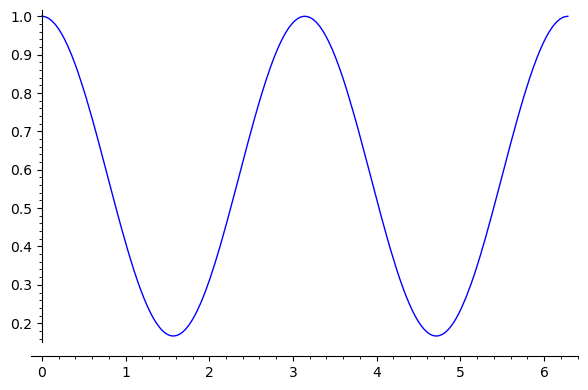

In [33]:
plot(obter_curv_normal(toro_part, u, v, 0, 0, vetor_unit, t), 
    (t, 0, 2*pi) )

### Cilindro

Em seguida, descrevemos o cilindro através da seguinte carta.

$$
\text{Cilindro}(u,v) :=
\left(
    r \cos u,
    r \sin u,
    v
\right)
$$

com $r \in \mathbb{R}$ constante.

In [34]:
cilindro(u,v) = ( r*cos(u), r*sin(u), v )

Como anteriormente, escolhemos um caso particular para visualizar a superfície. Optaremos por $a=2$ e $r=1$.

In [35]:
cilindro_unit = cilindro.subs([a==2, r==1])
parametric_plot3d(cilindro_unit,(u, 0, 2*pi), (v, 0, 2*pi), mesh=True)

Graphics3d Object

Ao calcular o operador de forma do cilindro, uma observação interessante surge.

In [36]:
cilindro_forma_u, cilindro_forma_v = obter_operador_forma(cilindro, 
                                                            u, v)
pretty_results((r"S(X_u)", cilindro_forma_u), 
               (r"S(X_v)", cilindro_forma_v))

\begin{align*} S(X_u) &= -\frac{X_{u}}{r} \\ S(X_v) &= 0 \\ \end{align*} \\

Note que $S(X_u)$ do cilindro é idêntico a $S(X_u)$ da esfera! Intuitivamente, o resultado faz sentido, uma vez que tanto o cilindro como a esfera têm um aspecto circular. Ainda assim, o que diferencia as duas superfícies é o fato de $S(X_v)$ ser nulo. Ou seja, a superfície não se curva em uma determinada direção.

### Sela

Outra superfície curiosa é a sela, que pode ser expressa através da seguinte carta

$$
\text{Sela}(u,v) :=
\left(
    u, v, u v
\right)
$$

In [37]:
sela(u,v) = (u, v, u*v)

Plotando a superfície, nos obtemos a seguinte visualização.

In [38]:
parametric_plot3d(sela,(u, -5, 5), (v, -5, 5), mesh=True)

Graphics3d Object

Calculando o operador de forma da sela, obtemos alguns resultados significantemente mais complexos que anteriormente.

In [39]:
sela_forma_u, sela_forma_v = obter_operador_forma(sela, u, v)
pretty_results((r"S(X_u)", sela_forma_u), (r"S(X_v)", sela_forma_v))

\begin{align*} S(X_u) &= -\frac{{\left(X_{u} u v - X_{v} v^{2} - X_{v}\right)} \sqrt{u^{2} + v^{2} + 1}}{u^{4} + v^{4} + 2 \, {\left(u^{2} + 1\right)} v^{2} + 2 \, u^{2} + 1} \\ S(X_v) &= \frac{{\left(X_{u} u^{2} - X_{v} u v + X_{u}\right)} \sqrt{u^{2} + v^{2} + 1}}{u^{4} + v^{4} + 2 \, {\left(u^{2} + 1\right)} v^{2} + 2 \, u^{2} + 1} \\ \end{align*} \\

Como é possível imaginar, o mesmo se dá na matriz do operador.

In [40]:
sela_matriz_forma = obter_matriz_forma(sela, u, v)
pretty_results((r"W_{\text{sela}}", sela_matriz_forma))

\begin{align*} W_{\text{sela}} &= \left(\begin{array}{rr}
-\frac{u v}{{\left(u^{2} + v^{2} + 1\right)}^{\frac{3}{2}}} & \frac{u^{2} + 1}{{\left(u^{2} + v^{2} + 1\right)}^{\frac{3}{2}}} \\
\frac{v^{2} + 1}{{\left(u^{2} + v^{2} + 1\right)}^{\frac{3}{2}}} & -\frac{u v}{{\left(u^{2} + v^{2} + 1\right)}^{\frac{3}{2}}}
\end{array}\right) \\ \end{align*} \\

Graças às ferramentas de computação simbólica, é ainda possível tirar proveito de tais representações. Uma análise é o estudo da curvatura com bases nos autovalores e no determinante da matriz $W_\text{Sela}$. 

A curvatura gaussiana é dada por

In [41]:
sela_k = obter_curv_gauss(sela, u, v)
pretty_results((r"K_{\text{Sela}}", sela_k))

\begin{align*} K_{\text{Sela}} &= -\frac{1}{u^{4} + v^{4} + 2 \, {\left(u^{2} + 1\right)} v^{2} + 2 \, u^{2} + 1} \\ \end{align*} \\

Por sua vez, as *curvaturas principais* da sela são dadas por

In [42]:
sela_kappa1, sela_kappa2 = obter_curv_princ(sela, u, v)
pretty_results((r"\kappa_1", sela_kappa1), (r"\kappa_2", sela_kappa2))

\begin{align*} \kappa_1 &= -\frac{\sqrt{u^{2} + v^{2} + 1} u v + \sqrt{{\left(u^{2} + 1\right)} v^{4} + u^{4} + {\left(u^{4} + 3 \, u^{2} + 2\right)} v^{2} + 2 \, u^{2} + 1}}{u^{4} + v^{4} + 2 \, {\left(u^{2} + 1\right)} v^{2} + 2 \, u^{2} + 1} \\ \kappa_2 &= -\frac{\sqrt{u^{2} + v^{2} + 1} u v - \sqrt{{\left(u^{2} + 1\right)} v^{4} + u^{4} + {\left(u^{4} + 3 \, u^{2} + 2\right)} v^{2} + 2 \, u^{2} + 1}}{u^{4} + v^{4} + 2 \, {\left(u^{2} + 1\right)} v^{2} + 2 \, u^{2} + 1} \\ \end{align*} \\

E assim, a curvatura média é

In [43]:
sela_h = obter_curv_media(sela, u, v)
pretty_results((r"H_{\text{Sela}}", sela_k))

\begin{align*} H_{\text{Sela}} &= -\frac{1}{u^{4} + v^{4} + 2 \, {\left(u^{2} + 1\right)} v^{2} + 2 \, u^{2} + 1} \\ \end{align*} \\

### Hiperbolóide de Uma Folha

Agora, analisaremos o hiperbolóide de uma folha. Geralmente, essa superfície é descrita pela carta

$$
\text{Hip}(u,v) :=
\left(
    \cosh(u) \cos(v),
    \cosh(u) \sin(v),
    u
\right)
$$

In [44]:
hip_uma_folha(u,v) = ( cosh(u)*cos(v), cosh(u)*sin(v), u)

Quando plotada, a superfície tem a seguinte aparência.

In [45]:
parametric_plot3d(hip_uma_folha,(u, -2, 2), (v, 0, 2*pi), 
                  mesh=True)

Graphics3d Object

Calculamos em seguida, o operador de forma da superfície.

In [46]:
hip_forma_u, hip_forma_v = obter_operador_forma(hip_uma_folha, u, v)
pretty_results((r"S(X_u)", hip_forma_u), (r"S(X_v)", hip_forma_v))

\begin{align*} S(X_u) &= -\frac{X_{u}}{\cosh\left(u\right)^{2}} \\ S(X_v) &= \frac{X_{v}}{\cosh\left(u\right)^{2}} \\ \end{align*} \\

Observe que há uma certa simetria entre $S(X_u)$ e $S(X_v)$, que reflete a visualização da superfície.

## 4. Superfícies de Revolução

Através da computação simbólica, é possível analisar inteiras classes de superfícies. Considere a forma geral de uma superfície de revolução. 

$$
\text{SupRev}(u,v) :=
\left(
    g(u), h(u) \cos(v), h(u) \sin(v)
\right)
$$

Utilizando funções simbólicas, podemos instanciar a aplicação acima em SageMath.

In [47]:
g = function('g' ,nargs=1)(u)
h = function('h' ,nargs=1)(u)

sup_rev(u,v) = ( g(u), h(u)*cos(v), h(u)*sin(v) )

Usando a mesma função que anteriormente, conseguimos calcular o operador de forma para tais superfícies.

In [48]:
sup_rev_forma_u, sup_rev_forma_v = obter_operador_forma(sup_rev, u, v)
pretty_results((r"S(X_u)", sup_rev_forma_u(x_u)), 
               (r"S(X_v)", sup_rev_forma_v(x_v)))

\begin{align*} S(X_u) &= \frac{x_{u} \frac{\partial^{2}}{(\partial u)^{2}}g\left(u\right) \frac{\partial}{\partial u}h\left(u\right) - x_{u} \frac{\partial}{\partial u}g\left(u\right) \frac{\partial^{2}}{(\partial u)^{2}}h\left(u\right)}{{\left(\frac{\partial}{\partial u}g\left(u\right)^{2} + \frac{\partial}{\partial u}h\left(u\right)^{2}\right)}^{\frac{3}{2}}} \\ S(X_v) &= \frac{x_{v} \frac{\partial}{\partial u}g\left(u\right)}{\sqrt{\frac{\partial}{\partial u}g\left(u\right)^{2} + \frac{\partial}{\partial u}h\left(u\right)^{2}} h\left(u\right)} \\ \end{align*} \\

Também é possível obter a matriz referente ao operador de forma.

In [49]:
sup_rev_matriz_forma = obter_matriz_forma(sup_rev, u, v)
pretty_results((r"W_{\text{SupRev}}", sup_rev_matriz_forma(u,v)))

\begin{align*} W_{\text{SupRev}} &= \left(\begin{array}{rr}
\frac{\frac{\partial^{2}}{(\partial u)^{2}}g\left(u\right) \frac{\partial}{\partial u}h\left(u\right) - \frac{\partial}{\partial u}g\left(u\right) \frac{\partial^{2}}{(\partial u)^{2}}h\left(u\right)}{{\left(\frac{\partial}{\partial u}g\left(u\right)^{2} + \frac{\partial}{\partial u}h\left(u\right)^{2}\right)}^{\frac{3}{2}}} & 0 \\
0 & \frac{\frac{\partial}{\partial u}g\left(u\right)}{\sqrt{\frac{\partial}{\partial u}g\left(u\right)^{2} + \frac{\partial}{\partial u}h\left(u\right)^{2}} h\left(u\right)}
\end{array}\right) \\ \end{align*} \\

Curiosamente, é possível ainda estender essa análise e considerar a curvatura gaussiana de uma superfície de revolução.

In [50]:
sup_rev_k = obter_curv_gauss(sup_rev, u, v)
pretty_results((r"K_{\text{SupRev}}", sup_rev_k(u,v)))

\begin{align*} K_{\text{SupRev}} &= \frac{\frac{\partial}{\partial u}g\left(u\right) \frac{\partial^{2}}{(\partial u)^{2}}g\left(u\right) \frac{\partial}{\partial u}h\left(u\right) - \frac{\partial}{\partial u}g\left(u\right)^{2} \frac{\partial^{2}}{(\partial u)^{2}}h\left(u\right)}{h\left(u\right) \frac{\partial}{\partial u}g\left(u\right)^{4} + 2 \, h\left(u\right) \frac{\partial}{\partial u}g\left(u\right)^{2} \frac{\partial}{\partial u}h\left(u\right)^{2} + h\left(u\right) \frac{\partial}{\partial u}h\left(u\right)^{4}} \\ \end{align*} \\

## 4. Superfícies Regradas

Outra aplicação interessante da computação simbólica é com relação às superfícies regradas. Fornecendo curvas $\beta(u)$ e $\delta(u)$, podemos construir a superfície regrada correspondente. A função seguinte implementa essa ideia.

In [51]:
def obter_superficie_regrada(beta, delta, u, v):
    carta = beta(u) + v*delta(u)
    return carta.function(u,v)

Com isso, podemos estudar uma série de superfícies regradas.

### Cilindro Generalizado

O primeiro exemplo de uma superfície construída desse modo é o cilindro generalizado. Note que fixando a coordenada $z$ no cilindro obtemos sempre um círculo. Aproveitaremos essa característica para construir a superfície.

In [52]:
circ(u) = ( cos(u), sin(u), 0)
vec(u) = (0, 1, 1)

cilindro_gen = obter_superficie_regrada(circ, vec, u, v)

In [53]:
pretty_results((r"\text{CilindroGeneralizado}(u,v)", cilindro_gen(u,v)),
               use_colon=False)

\begin{align*} \text{CilindroGeneralizado}(u,v) &= \left(\cos\left(u\right),\,v + \sin\left(u\right),\,v\right) \\ \end{align*} \\

Plotando a aplicação, obtemos

In [54]:
parametric_plot3d(cilindro_gen,(u, 0, 2*pi), (v, -1, 1), mesh=True)

Graphics3d Object

### Sela Regrada

Embora tenhamos considerado a sela anteriormente, ela também admite uma construção como superfície regrada. Basta tomar

In [55]:
reta_1(u) = (u, 0, 0)
reta_2(u) = (0, 1, u)

sela_reg = obter_superficie_regrada(reta_1, reta_2, u, v)

In [56]:
pretty_results((r"\text{SelaGeneralizada}(u,v)", sela_reg(u,v)))

\begin{align*} \text{SelaGeneralizada}(u,v) &= \left(u,\,v,\,u v\right) \\ \end{align*} \\

Assim, obtemos a mesma aplicação vista anteriormente. 

In [57]:
parametric_plot3d(sela_reg, (u, -5, 5), (v, -5, 5), mesh=True)

Graphics3d Object

## 5. Desenvolvíveis Tangentes

Por fim, consideramos os *desenvolvíveis tangentes*. Os desenvolvíveis tangentes são um caso específico de superfícies regradas no qual

$$
\delta(u) = \beta'(u)
$$

Através do SageMath, podemos gerar superfícies desse tipo automaticamente.

In [58]:
def obter_desenvolvivel_tangente(carta, u, v):
    derivada_carta = derivative(carta, u)
    
    desenvolvivel = obter_superficie_regrada(carta, derivada_carta,
                                             u, v)
    
    return desenvolvivel

### Hélice Desenvolvível

Um exemplo ilustrativo de desenvolvíveis tangentes é a hélice desenvolvível.

In [59]:
helice(u) = ( cos(u), sin(u), u )

helice_des = obter_desenvolvivel_tangente(helice, u, v)

In [60]:
pretty_results((r"\text{HéliceDesenvolvível}", 
                helice_des(u,v)))

\begin{align*} \text{HéliceDesenvolvível} &= \left(-v \sin\left(u\right) + \cos\left(u\right),\,v \cos\left(u\right) + \sin\left(u\right),\,u + v\right) \\ \end{align*} \\

In [61]:
parametric_plot3d(helice_des, (u, 0, 3.5*pi), (v, -4, 4), 
                  mesh=True)

Graphics3d Object

Alterando os parâmetros do domínio, é possível também visualizar a meia-hélice.

In [62]:
parametric_plot3d(helice_des, (u, 0, 3.5*pi), (v, 0, 4), 
                  mesh=True)

Graphics3d Object

Como em casos anteriores, também é possível obter o operador de forma para essa superfície.

In [63]:
hel_des_forma_u, hel_des_forma_v = obter_operador_forma(helice_des, 
                                                          u, v)
pretty_results((r"S(X_u)", hel_des_forma_u), 
               (r"S(X_v)", hel_des_forma_v))

\begin{align*} S(X_u) &= -\frac{\sqrt{2} X_{u} - \sqrt{2} X_{v}}{2 \, v} \\ S(X_v) &= 0 \\ \end{align*} \\

In [64]:
hel_des_matriz_forma = obter_matriz_forma(helice_des, u, v)
pretty_results((r"W_{\text{HéliceDesenvolvível}}", 
                hel_des_matriz_forma))

\begin{align*} W_{\text{HéliceDesenvolvível}} &= \left(\begin{array}{rr}
-\frac{\sqrt{2}}{2 \, v} & 0 \\
\frac{\sqrt{2}}{2 \, v} & 0
\end{array}\right) \\ \end{align*} \\

Observe que $S(X_v)$ nulo indique a ausência de curvatura em um determinada direção. Calculando as curvatura gaussiana e média para tais superfícies, nós obtemos

In [65]:
hel_des_k = obter_curv_gauss(helice_des, u, v)
pretty_results((r"K_{\text{HéliceDesenvolvível}}", hel_des_k))

\begin{align*} K_{\text{HéliceDesenvolvível}} &= 0 \\ \end{align*} \\

In [66]:
hel_des_h = obter_curv_media(helice_des, u, v)
pretty_results((r"H_{\text{HéliceDesenvolvível}}", hel_des_k))

\begin{align*} H_{\text{HéliceDesenvolvível}} &= 0 \\ \end{align*} \\

### Desenvolvível Tangente de Seno

Experimentar com diferentes curvas de base resulta em resultados supreendentes. Considere o caso da seguinte curva.

In [67]:
n = var('n')

seno_n(u) = (0, 0, sin(n*u))

Testando diferentes valores por $n$ obtemos diversas superfícies curiosas.

In [68]:
curv_seno = seno_n.subs([n==1])

sup_reg_1 = obter_superficie_regrada(curv_seno, circ, u, v)
pretty_results((r"\text{SupSeno}_n(u,v)", sup_reg_1(u,v)))

\begin{align*} \text{SupSeno}_n(u,v) &= \left(v \cos\left(u\right),\,v \sin\left(u\right),\,\sin\left(u\right)\right) \\ \end{align*} \\

In [69]:
parametric_plot3d(sup_reg_1, (u, 0, 2*pi), (v, -1, 1), mesh=True)

Graphics3d Object

### Desenvolvível Tangente de Curva Esférica

Um desenvolvível tangente final interessante é aquele gerado por uma curva esférica.

In [70]:
curv_esfer(u,v) = (cos(u)*cos(2*u), sin(u)*cos(2*u), sin(2*u))

Certas visualizações dessa curvas são instrutivas para compreender o seu o nome. Na plotagem a seguir, temos a curva esférica sobreposta em uma esfera unitária.

In [71]:
graf_1 = Graphics()
graf_1 += parametric_plot3d(esfera_unit, (u, 0, 2*pi), (v, 0, 2*pi),
                            opacity=0.2)
graf_1 += parametric_plot3d(curv_esfer, (u, 0, 2*pi), 
                            color="cornflowerblue", thickness=10)
graf_1.show()

Graphics3d Object

Note que a curva está completamente contida na superfície da esfera. Em seguida, geramos o desenvolvível tangente dessa curva.

In [72]:
des_tan_1 = obter_desenvolvivel_tangente(curv_esfer, u, v)
pretty_results((r"\text{DesTan}_1(u,v)", des_tan_1(u,v)))

\begin{align*} \text{DesTan}_1(u,v) &= \left(-{\left(2 \, \cos\left(u\right) \sin\left(2 \, u\right) + \cos\left(2 \, u\right) \sin\left(u\right)\right)} v + \cos\left(2 \, u\right) \cos\left(u\right),\,{\left(\cos\left(2 \, u\right) \cos\left(u\right) - 2 \, \sin\left(2 \, u\right) \sin\left(u\right)\right)} v + \cos\left(2 \, u\right) \sin\left(u\right),\,2 \, v \cos\left(2 \, u\right) + \sin\left(2 \, u\right)\right) \\ \end{align*} \\

Plotando essa aplicação, chegamos a uma superfície com um formato realmente curioso.

In [73]:
parametric_plot3d(des_tan_1, (u, 0, 2*pi), (v, -1, 1), mesh=True)

Graphics3d Object

## Conclusão

Ao longo deste trabalho, consideramos uma variedade de superfícies. Exploramos a visualização delas e a computação automática de algumas de suas propriedades. Consideramos também como é possível analisar classes inteiras de superfícies através de ferramentas computacionais. Sem dúvida, a computação simbólica fornece uma contribuição significante para o estudo da geometria diferencial!

## Referências

1. OPREA, John. **Differential Geometry and Its Applications**. 2. ed. Washington, Dc: Mathematical Association Of America, 2007. 469 p.

2. PRESSLEY, Andrew. **Elementary Differential Geometry.** 2. ed. London: Springer, 2010.

3.  CARMO, Manfredo P. do. **Differential Geometry of Curves & Surfaces.** 2. ed. Mineola, New York: Dover Publications, Inc., 2016.